# 1. Data Preprocessing

In [1]:
import uproot
import awkward as ak
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler


In [2]:
# Define file paths (update these based on your actual data path)
egamma_file = "C:/Users/vudut/OneDrive/Desktop/Python/MINI Project/Data Sets/complete_set_of_ATLAS_open_data_samples_July_2016/Data/DataEgamma.root"
muons_file = "C:/Users/vudut/OneDrive/Desktop/Python/MINI Project/Data Sets/complete_set_of_ATLAS_open_data_samples_July_2016/Data/DataMuons.root"

# Open ROOT files and list available trees
with uproot.open(egamma_file) as f:
    print(f.keys())  # Lists available trees

with uproot.open(muons_file) as f:
    print(f.keys())  # Lists available trees


['mini;1']
['mini;1']


In [3]:
tree_name = "mini"  # Confirm this from the output of f.keys()

In [4]:
with uproot.open(egamma_file) as f:
    tree = f[tree_name]
    print(tree.keys())  # Lists available branches (features)


['runNumber', 'eventNumber', 'channelNumber', 'mcWeight', 'pvxp_n', 'vxp_z', 'scaleFactor_PILEUP', 'scaleFactor_ELE', 'scaleFactor_MUON', 'scaleFactor_BTAG', 'scaleFactor_TRIGGER', 'scaleFactor_JVFSF', 'scaleFactor_ZVERTEX', 'trigE', 'trigM', 'passGRL', 'hasGoodVertex', 'lep_n', 'lep_truthMatched', 'lep_trigMatched', 'lep_pt', 'lep_eta', 'lep_phi', 'lep_E', 'lep_z0', 'lep_charge', 'lep_type', 'lep_flag', 'lep_ptcone30', 'lep_etcone20', 'lep_trackd0pvunbiased', 'lep_tracksigd0pvunbiased', 'met_et', 'met_phi', 'jet_n', 'alljet_n', 'jet_pt', 'jet_eta', 'jet_phi', 'jet_E', 'jet_m', 'jet_jvf', 'jet_trueflav', 'jet_truthMatched', 'jet_SV0', 'jet_MV1']


In [5]:
# Select relevant features for particle classification
branches_to_load = [
    "lep_pt", "lep_eta", "lep_phi", "lep_E",  # Lepton kinematics
    "lep_charge", "lep_type", "jet_n", "jet_pt",  # Jet properties
    "met_et", "met_phi"  # Missing transverse energy
]

In [6]:
# Load data into Pandas DataFrame
def load_root_data(file_path, tree_name, branches):
    with uproot.open(file_path) as f:
        tree = f[tree_name]
        data = tree.arrays(branches, library="pd")  # Convert to Pandas DataFrame
    return data

df_egamma = load_root_data(egamma_file, tree_name, branches_to_load)
df_muons = load_root_data(muons_file, tree_name, branches_to_load)

# Display first few rows
print(df_egamma.head())
print(df_muons.head())


                          lep_pt                                      lep_eta  \
0                [27587.1171875]                        [-1.3134968280792236]   
1  [45430.203125, 41510.0234375]  [-0.39944201707839966, 0.25652745366096497]   
2               [39664.33203125]                         [0.5096074342727661]   
3              [27585.826171875]                        [0.44308215379714966]   
4               [33562.00390625]                         [1.1484966278076172]   

                                     lep_phi  \
0                       [0.6908043026924133]   
1  [1.6501771211624146, -1.2450007200241089]   
2                      [-0.9465420842170715]   
3                       [1.5666908025741577]   
4                      [-1.6402952671051025]   

                              lep_E   lep_charge  lep_type  jet_n  \
0                      [55009.1875]        [1.0]      [11]      1   
1  [49102.93359375, 42883.33984375]  [-1.0, 1.0]  [11, 11]      0   
2                

In [7]:
def load_root_data(file_path, tree_name, branches):
    with uproot.open(file_path) as f:
        tree = f[tree_name]
        data = tree.arrays(branches, library="pd")  # Convert to Pandas DataFrame
        
        # Convert awkward arrays to regular numpy arrays for compatibility
        for column in data.columns:
            data[column] = ak.to_numpy(data[column])  # Convert awkward array to numpy array
            
    return data


In [8]:
# Check for missing values
print(df_egamma.isnull().sum())
print(df_muons.isnull().sum())

# Fill missing values with the median
df_egamma = df_egamma.apply(lambda x: x.fillna(x.median()) if x.dtype.kind in 'fi' else x)
df_muons = df_muons.apply(lambda x: x.fillna(x.median()) if x.dtype.kind in 'fi' else x)


lep_pt        0
lep_eta       0
lep_phi       0
lep_E         0
lep_charge    0
lep_type      0
jet_n         0
jet_pt        0
met_et        0
met_phi       0
dtype: int64
lep_pt        0
lep_eta       0
lep_phi       0
lep_E         0
lep_charge    0
lep_type      0
jet_n         0
jet_pt        0
met_et        0
met_phi       0
dtype: int64


In [9]:
# Convert all awkward arrays to regular NumPy arrays
df_egamma = df_egamma.map(lambda x: ak.to_numpy(x) if isinstance(x, ak.Array) else x)
df_muons = df_muons.map(lambda x: ak.to_numpy(x) if isinstance(x, ak.Array) else x)

In [10]:
for col in df_egamma.columns:
    if isinstance(df_egamma[col].iloc[0], (list, np.ndarray, ak.Array)):
        print(f"Column {col} has nested lists.")

Column lep_pt has nested lists.
Column lep_eta has nested lists.
Column lep_phi has nested lists.
Column lep_E has nested lists.
Column lep_charge has nested lists.
Column lep_type has nested lists.
Column jet_pt has nested lists.


In [11]:
def flatten_column(df, col):
    """Convert list-like columns into single-value scalars."""
    if df[col].apply(lambda x: isinstance(x, (list, np.ndarray, ak.Array))).any():
        df[col] = df[col].apply(lambda x: np.mean(x) if len(x) > 0 else np.nan)  # Use mean value
    return df

# Apply the function to all columns
for col in df_egamma.columns:
    df_egamma = flatten_column(df_egamma, col)
for col in df_muons.columns:
    df_muons = flatten_column(df_muons, col)

In [12]:
for col in df_egamma.columns:
    df_egamma[col] = ak.to_numpy(df_egamma[col])

for col in df_muons.columns:
    df_muons[col] = ak.to_numpy(df_muons[col])


In [13]:
scaler = StandardScaler()
scaled_columns = ["lep_pt", "lep_eta", "lep_phi", "lep_E", "jet_pt", "met_et"]

df_egamma[scaled_columns] = scaler.fit_transform(df_egamma[scaled_columns])
df_muons[scaled_columns] = scaler.transform(df_muons[scaled_columns])  # Use the same scaler


In [14]:
# Combine both datasets before splitting (optional, if needed)
df_combined = pd.concat([df_egamma, df_muons], axis=0)

# Define target variable (classification label)
y = df_combined["lep_type"]  # Adjust based on available target
X = df_combined.drop(columns=["lep_type"])  # Drop target from features

# Split into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"Training Set: {X_train.shape}, Validation Set: {X_val.shape}, Test Set: {X_test.shape}")


Training Set: (10461971, 9), Validation Set: (2241851, 9), Test Set: (2241852, 9)


In [15]:
print("Unique labels in y_train:", y_train.unique())
print("Unique labels in y_val:", y_val.unique())
print("Unique labels in y_test:", y_test.unique())


Unique labels in y_train: [11.         13.         12.         11.66666667 12.33333333 11.5
 12.6        12.5        12.2       ]
Unique labels in y_val: [11.         13.         12.         12.33333333 11.66666667 12.5
 11.5        12.6       ]
Unique labels in y_test: [11.         13.         12.         12.33333333 11.66666667 11.5
 12.5       ]


In [16]:
# Map labels to zero-based index
unique_classes = sorted(y_train.unique())  # Sort to ensure proper mapping
class_mapping = {cls: i for i, cls in enumerate(unique_classes)}

# Apply mapping
y_train = y_train.map(class_mapping)
y_val = y_val.map(class_mapping)
y_test = y_test.map(class_mapping)

print("Updated class labels:", y_train.unique())


Updated class labels: [0 8 3 2 5 1 7 6 4]


In [17]:
# Save preprocessed data
df_combined.to_csv("preprocessed_data.csv", index=False)

print("✅ Preprocessed data saved successfully!")

✅ Preprocessed data saved successfully!


# 2. Model Building

## XGBoost Model for tabular data

In [ ]:
import xgboost as xgb
import pandas as pd
import numpy as np
import wandb  # Weights & Biases
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from tensorboardX import SummaryWriter  # TensorBoard


In [ ]:
wandb.init(project="xgboost-particle-classification", name="XGBoost-Run-1")

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: vuduthasaipraneetham (praneetham) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [ ]:
import os
from tensorboardX import SummaryWriter

# Define TensorBoard log directory
log_dir = "logs/xgboost"
os.makedirs(log_dir, exist_ok=True)

# Initialize TensorBoard Writer
writer = SummaryWriter(log_dir)


In [ ]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)

params = {
    "objective": "multi:softprob",  # Use softprob for probability outputs
    "num_class": len(y_train.unique()), 
    "eval_metric": "mlogloss",
    "max_depth": 6,
    "learning_rate": 0.1,
    "n_estimators": 100
}


model = xgb.train(
    params, dtrain,
    evals=[(dval, "validation")],
    num_boost_round=100,
    early_stopping_rounds=10,
    verbose_eval=True
)



c:\Users\vudut\anaconda3\envs\MINI_PROJECT\lib\site-packages\xgboost\core.py:158: UserWarning: [22:15:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation-mlogloss:1.99530
[1]	validation-mlogloss:1.83751
[2]	validation-mlogloss:1.70951
[3]	validation-mlogloss:1.60204
[4]	validation-mlogloss:1.51051
[5]	validation-mlogloss:1.43148
[6]	validation-mlogloss:1.36243
[7]	validation-mlogloss:1.30162
[8]	validation-mlogloss:1.24779
[9]	validation-mlogloss:1.19994
[10]	validation-mlogloss:1.15666
[11]	validation-mlogloss:1.11801
[12]	validation-mlogloss:1.08298
[13]	validation-mlogloss:1.05091
[14]	validation-mlogloss:1.02198
[15]	validation-mlogloss:0.99551
[16]	validation-mlogloss:0.97129
[17]	validation-mlogloss:0.94943
[18]	validation-mlogloss:0.92903
[19]	validation-mlogloss:0.91061
[20]	validation-mlogloss:0.89356
[21]	validation-mlogloss:0.87787
[22]	validation-mlogloss:0.86323
[23]	validation-mlogloss:0.84960
[24]	validation-mlogloss:0.83690
[25]	validation-mlogloss:0.82522
[26]	validation-mlogloss:0.81440
[27]	validation-mlogloss:0.80437
[28]	validation-mlogloss:0.79515
[29]	validation-mlogloss:0.78643
[30]	validation-mlog

In [ ]:
print(f"Unique classes in y_test: {np.unique(y_test)}")
print(f"Shape of y_proba: {y_proba.shape}")  # Should be (num_samples, num_classes)
print(f"Shape of y_test: {y_test.shape}")    # Should be (num_samples,)


Unique classes in y_test: [0 1 2 3 5 6 8]


NameError: name 'y_proba' is not defined

In [2]:
from sklearn.preprocessing import label_binarize

# Ensure y_test has the same number of classes as y_proba
y_test_binarized = label_binarize(y_test, classes=np.arange(y_proba.shape[1]))

# Compute evaluation metrics
metrics = {
    "accuracy": accuracy_score(y_test, y_pred),
    "precision": precision_score(y_test, y_pred, average="weighted"),
    "recall": recall_score(y_test, y_pred, average="weighted"),
    "f1_score": f1_score(y_test, y_pred, average="weighted"),
    "auc_roc": roc_auc_score(y_test_binarized, y_proba, multi_class="ovr")
}

print("📊 Model Performance:")
for key, value in metrics.items():
    print(f"{key}: {value:.4f}")


NameError: name 'y_test' is not defined

In [ ]:
writer = SummaryWriter("logs/xgboost")
for key, value in metrics.items():
    writer.add_scalar(f"Metrics/{key}", value)
writer.close()

NaN or Inf found in input tensor.


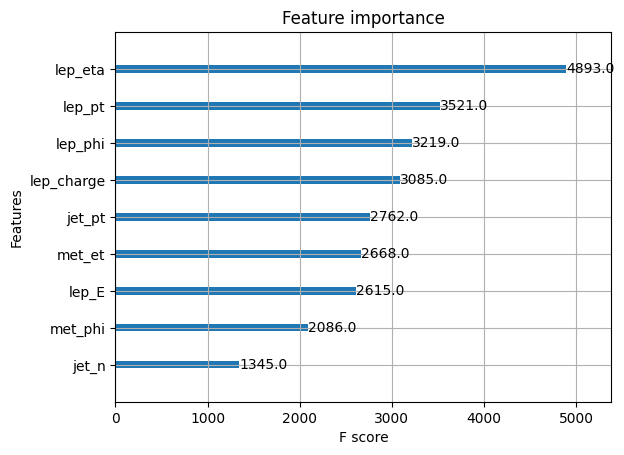

In [ ]:
import matplotlib.pyplot as plt
xgb.plot_importance(model)
plt.show()

In [ ]:
import optuna

def objective(trial):
    params = {
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "n_estimators": trial.suggest_int("n_estimators", 50, 500),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0)
    }
    model = xgb.XGBClassifier(**params)
    model.fit(X_train, y_train)
    return accuracy_score(y_val, model.predict(X_val))

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=20)

print("Best hyperparameters:", study.best_params)


c:\Users\vudut\anaconda3\envs\MINI_PROJECT\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2025-02-21 22:39:32,537] A new study created in memory with name: no-name-365b0d43-d8a2-46f1-b0aa-c29069065e07
[I 2025-02-21 23:09:11,001] Trial 0 finished with value: 0.635310286009195 and parameters: {'max_depth': 5, 'learning_rate': 0.15230908734995077, 'n_estimators': 498, 'subsample': 0.6210597542812815}. Best is trial 0 with value: 0.635310286009195.
[I 2025-02-21 23:14:51,423] Trial 1 finished with value: 0.6178974427827719 and parameters: {'max_depth': 3, 'learning_rate': 0.09226401457039649, 'n_estimators': 115, 'subsample': 0.652485389079733}. Best is trial 0 with value: 0.635310286009195.


In [ ]:
import onnxruntime as ort
print(ort.get_device())

CPU-DML


In [ ]:
import onnxruntime as ort
print(ort.get_available_providers())


['DmlExecutionProvider', 'CPUExecutionProvider']


In [ ]:
# Rename feature columns to follow ONNX expected format
X_train_renamed = X_train.copy()
X_test_renamed = X_test.copy()
X_train_renamed.columns = [f"f{i}" for i in range(X_train.shape[1])]
X_test_renamed.columns = X_train_renamed.columns  # Ensure same naming in test set


In [ ]:
# Retrain the model with updated column names
dtrain = xgb.DMatrix(X_train_renamed, label=y_train)
dtest = xgb.DMatrix(X_test_renamed, label=y_test)

params = {
    "objective": "multi:softmax",
    "num_class": len(y_train.unique()),
    "max_depth": 6,
    "learning_rate": 0.1,
    "eval_metric": "mlogloss",
    "n_estimators": 100
}

# Train the model
model = xgb.train(params, dtrain)


c:\Users\vudut\anaconda3\envs\MINI_PROJECT\lib\site-packages\xgboost\core.py:158: UserWarning: [22:32:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


In [ ]:
import xgboost as xgb
import onnxmltools
import skl2onnx
from skl2onnx.common.data_types import FloatTensorType

# Define input shape
initial_type = [("float_input", FloatTensorType([None, X_train.shape[1]]))]

# Convert to ONNX
onnx_model = onnxmltools.convert_xgboost(model, initial_types=initial_type)

# Save the ONNX model
onnx_path = "xgboost_model.onnx"
onnxmltools.utils.save_model(onnx_model, onnx_path)

print(f"✅ Model saved as: {onnx_path}")

✅ Model saved as: xgboost_model.onnx


In [ ]:
import onnxruntime as ort

# Load ONNX model with DirectML
session = ort.InferenceSession("xgboost_model.onnx", providers=["DmlExecutionProvider"])

print(session.get_providers())  # Should include 'DmlExecutionProvider'


['DmlExecutionProvider', 'CPUExecutionProvider']


In [ ]:
import onnxruntime as ort
import numpy as np

# Load the ONNX model with DirectML for AMD GPU
session = ort.InferenceSession("xgboost_model.onnx", providers=["DmlExecutionProvider"])

# Select a sample from test data for inference
sample_input = X_test.iloc[:5].to_numpy().astype(np.float32)

# Run inference
outputs = session.run(None, {"float_input": sample_input})

print("🟢 ONNX Inference Output:", outputs)


🟢 ONNX Inference Output: [array([8, 8, 8, 0, 0]), array([[ 1.3755537 , -0.04675478, -0.04649454, -0.04525429, -0.04676288,
        -0.04677039, -0.04675043, -0.04676354,  1.708995  ],
       [ 1.5388454 , -0.04675478, -0.04649454, -0.04199839, -0.04676288,
        -0.04677039, -0.04675043, -0.04676354,  1.5711285 ],
       [ 1.4228926 , -0.04675478, -0.04649454, -0.04525429, -0.04676288,
        -0.04677039, -0.04675043, -0.04676354,  1.623148  ],
       [ 1.8272315 , -0.04675478, -0.04649055, -0.04452735, -0.04676288,
        -0.04674762, -0.04675043, -0.04676354,  1.3570817 ],
       [ 1.6486268 , -0.04675478, -0.04649454, -0.04199839, -0.04676288,
        -0.04677039, -0.04675043, -0.04676354,  1.4112225 ]],
      dtype=float32)]


In [ ]:
options = ort.SessionOptions()
options.graph_optimization_level = ort.GraphOptimizationLevel.ORT_ENABLE_ALL

session = ort.InferenceSession("xgboost_model.onnx", options, providers=["DmlExecutionProvider"])

# Run batch inference
outputs = session.run(None, {"float_input": X_test.to_numpy().astype(np.float32)})

print("🟢 Optimized ONNX Inference Completed!")


🟢 Optimized ONNX Inference Completed!


In [ ]:
import wandb

# Initialize W&B project
wandb.init(project="xgboost-onnx-inference", name="ONNX DirectML Test")

# Log inference performance
wandb.log({"accuracy": accuracy_score(y_test, outputs[0])})

# Finish logging
wandb.finish()


accuracy,▁
accuracy,0.61039


# Optuna ONNX accelerated hyper parameter tuning

In [ ]:
# Rename feature columns to 'f0', 'f1', ..., 'fn'
feature_mapping = {col: f"f{i}" for i, col in enumerate(X_train.columns)}
X_train_renamed = X_train.rename(columns=feature_mapping)
X_val_renamed = X_val.rename(columns=feature_mapping)
X_test_renamed = X_test.rename(columns=feature_mapping)

# Apply same renaming to the entire dataset
X_train = X_train_renamed
X_val = X_val_renamed
X_test = X_test_renamed


In [ ]:
import xgboost as xgb

# Create DMatrix for training
dtrain = xgb.DMatrix(X_train, label=y_train)

# Define model parameters
params = {
    "objective": "multi:softmax",
    "num_class": len(y_train.unique()),
    "learning_rate": 0.1,
    "max_depth": 6,
    "n_estimators": 100
}

# Train XGBoost model
model = xgb.train(params, dtrain, num_boost_round=100)


c:\Users\vudut\anaconda3\envs\MINI_PROJECT\lib\site-packages\xgboost\core.py:158: UserWarning: [23:08:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


In [ ]:
import onnxmltools
from onnxmltools.convert.common.data_types import FloatTensorType

# Define input type
initial_type = [("float_input", FloatTensorType([None, X_train.shape[1]]))]

# Convert model to ONNX
onnx_model = onnxmltools.convert_xgboost(model, initial_types=initial_type)

# Save ONNX model
onnxmltools.utils.save_model(onnx_model, "xgboost_optimized.onnx")

print("✅ XGBoost Model successfully converted to ONNX!")


✅ XGBoost Model successfully converted to ONNX!


In [ ]:
import optuna
import onnxruntime as ort
import numpy as np
from sklearn.metrics import accuracy_score

# Load ONNX model for inference
session = ort.InferenceSession("xgboost_optimized.onnx", providers=["DmlExecutionProvider"])

# Define Optuna objective function
def objective(trial):
    # Suggest new hyperparameters
    subsample = trial.suggest_uniform("subsample", 0.5, 1.0)
    colsample_bytree = trial.suggest_uniform("colsample_bytree", 0.5, 1.0)

    # Select sample input
    sample_input = X_val.to_numpy().astype(np.float32)

    # Run inference on ONNX model
    y_pred = session.run(None, {"float_input": sample_input})[0]

    # Compute accuracy
    accuracy = accuracy_score(y_val, y_pred)
    return accuracy

# Run hyperparameter tuning
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=20)

print("🚀 Best Hyperparameters:", study.best_params)


[I 2025-02-22 23:25:01,465] A new study created in memory with name: no-name-bab39ddd-e8d2-4e0f-a538-1138734b340d
C:\Users\vudut\AppData\Local\Temp\ipykernel_26268\353039258.py:12: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform("subsample", 0.5, 1.0)
C:\Users\vudut\AppData\Local\Temp\ipykernel_26268\353039258.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform("colsample_bytree", 0.5, 1.0)
[I 2025-02-22 23:25:14,116] Trial 0 finished with value: 0.6277763330390824 and parameters: {'subsample': 0.9318864407073042, 'colsample_bytree': 0.9496918647401327}. Best is trial 0 with value: 0.6277763330390824.
C:\Users\vudut\AppData\Local\Te

🚀 Best Hyperparameters: {'subsample': 0.9318864407073042, 'colsample_bytree': 0.9496918647401327}


In [ ]:
import onnxruntime as ort

# Check available providers
print(ort.get_device())  # Should print 'GPU' if DirectML is active

# Check if DirectML is available
print(ort.get_available_providers())  # Should contain "DmlExecutionProvider"


CPU-DML
['DmlExecutionProvider', 'CPUExecutionProvider']


In [ ]:
import onnxruntime as ort

# Check which providers are available
print("Available Execution Providers:", ort.get_available_providers())

# Create DirectML session and check which device is being used
session = ort.InferenceSession("xgboost_optimized.onnx", providers=["DmlExecutionProvider"])
print("Execution Provider Details:", session.get_provider_options())


Available Execution Providers: ['DmlExecutionProvider', 'CPUExecutionProvider']
Execution Provider Details: {'DmlExecutionProvider': {}, 'CPUExecutionProvider': {}}


In [ ]:
import optuna
import onnxruntime as ort
import numpy as np
from sklearn.metrics import accuracy_score

# Load ONNX model with GPU acceleration
session = ort.InferenceSession(
    "xgboost_optimized.onnx",
    providers=["DmlExecutionProvider"],
    provider_options=[{"device_id": 0}]  # Change to 1 if needed
)

# Define Optuna objective function
def objective(trial):
    # Suggest hyperparameters
    subsample = trial.suggest_uniform("subsample", 0.5, 1.0)
    colsample_bytree = trial.suggest_uniform("colsample_bytree", 0.5, 1.0)

    # Convert input to float32 for ONNX
    sample_input = X_val.to_numpy().astype(np.float32)

    # Run inference on ONNX model using DirectML
    y_pred = session.run(None, {"float_input": sample_input})[0]

    # Compute accuracy
    accuracy = accuracy_score(y_val, y_pred)
    return accuracy

# Run hyperparameter tuning
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)  # Run 50 trials

print("✅ Hyperparameter tuning completed!")


[I 2025-02-22 23:37:44,606] A new study created in memory with name: no-name-078645e5-db51-4390-a696-bcd9e6bfde48
C:\Users\vudut\AppData\Local\Temp\ipykernel_26268\438963492.py:16: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform("subsample", 0.5, 1.0)
C:\Users\vudut\AppData\Local\Temp\ipykernel_26268\438963492.py:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform("colsample_bytree", 0.5, 1.0)
[I 2025-02-22 23:38:00,429] Trial 0 finished with value: 0.6277763330390824 and parameters: {'subsample': 0.9103341698375175, 'colsample_bytree': 0.7300943678128424}. Best is trial 0 with value: 0.6277763330390824.
C:\Users\vudut\AppData\Local\Te

KeyboardInterrupt: 